In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.metrics import precision_recall_curve, r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import GridSearchCV
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor 
from tensorflow.keras.callbacks import Callback, EarlyStopping

## Loading the final preprocessed trained dataset


In [2]:
full_cleaned_final= pd.read_csv('full_cleaned_final.csv').drop(columns=['Unnamed: 0'])
full_cleaned_final.shape

(4092, 9)

In [3]:
#loading the train set

full_cleaned_final_train= pd.read_csv('full_cleaned_final_train.csv').drop(columns=['Unnamed: 0'])
full_cleaned_final_train.shape

(2864, 9)

## Loading the test set

In [4]:
#Loading the test set
full_cleaned_final_test = pd.read_csv('full_cleaned_final_test.csv').drop(columns=['Unnamed: 0'])
full_cleaned_final_test.shape

(1228, 9)

In [5]:
len(full_cleaned_final_test.columns)

9

## Feature Engineering

In [6]:
full_cleaned_final_train.columns

Index(['scale__net_elec_imports', 'scale__per_capita_electricity',
       'scale__biofuel_elec_per_capita', 'scale__hydro_elec_per_capita',
       'scale__solar_elec_per_capita', 'scale__wind_elec_per_capita',
       'remainder__country', 'remainder__year', 'remainder__GDP_per_capita'],
      dtype='object')

In [7]:
full_cleaned_final_train['new_elec_per_capita'] = full_cleaned_final_train['scale__per_capita_electricity'] - full_cleaned_final_train['scale__hydro_elec_per_capita']
full_cleaned_final_test['new_elec_per_capita'] = full_cleaned_final_test['scale__per_capita_electricity'] - full_cleaned_final_test['scale__hydro_elec_per_capita']
full_cleaned_final['new_elec_per_capita'] = full_cleaned_final['scale__per_capita_electricity'] - full_cleaned_final['scale__hydro_elec_per_capita']


In [8]:
full_cleaned_final_train

,scale__net_elec_imports,scale__per_capita_electricity,scale__biofuel_elec_per_capita,scale__hydro_elec_per_capita,scale__solar_elec_per_capita,scale__wind_elec_per_capita,remainder__country,remainder__year,remainder__GDP_per_capita,new_elec_per_capita
0,0.536682,0.001896,0.000000,0.000000,0.000000,0.000000,Comoros,2018,1383.377789,0.001896
1,0.536682,0.011690,0.004495,0.003792,0.000000,0.000000,Congo,2020,1586.318297,0.007898
2,0.536682,0.147047,0.003190,0.001794,0.001342,0.002828,South Korea,2007,23360.905735,0.145253
3,0.537588,0.002427,0.000000,0.000390,0.000000,0.000000,Mauritania,2006,1601.141206,0.002037
4,0.538703,0.004056,0.000000,0.005729,0.000000,0.000000,Lesotho,2012,1075.620196,-0.001674
...,...,...,...,...,...,...,...,...,...,...
2859,0.536682,0.002856,0.000000,0.000000,0.000000,0.000000,Comoros,2021,1355.538730,0.002856
2860,0.537170,0.083870,0.000000,0.029741,0.000000,0.000000,Serbia,2008,5270.959534,0.054129
2861,0.588170,0.085270,0.000000,0.000000,0.000000,0.000000,Hong Kong,2003,28096.898252,0.085270
2862,0.541838,0.002090,0.000000,0.003040,0.000339,0.000000,Nepal,2011,748.012453,-0.000950


## Best features


In [9]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier

In [10]:
X = full_cleaned_final[['scale__net_elec_imports',
                        'new_elec_per_capita',
                        'scale__per_capita_electricity', 
                        'scale__biofuel_elec_per_capita',
                        'scale__hydro_elec_per_capita', 
                        'scale__solar_elec_per_capita',
                        'scale__wind_elec_per_capita'
                       ]]


y = full_cleaned_final.iloc[:,-1]


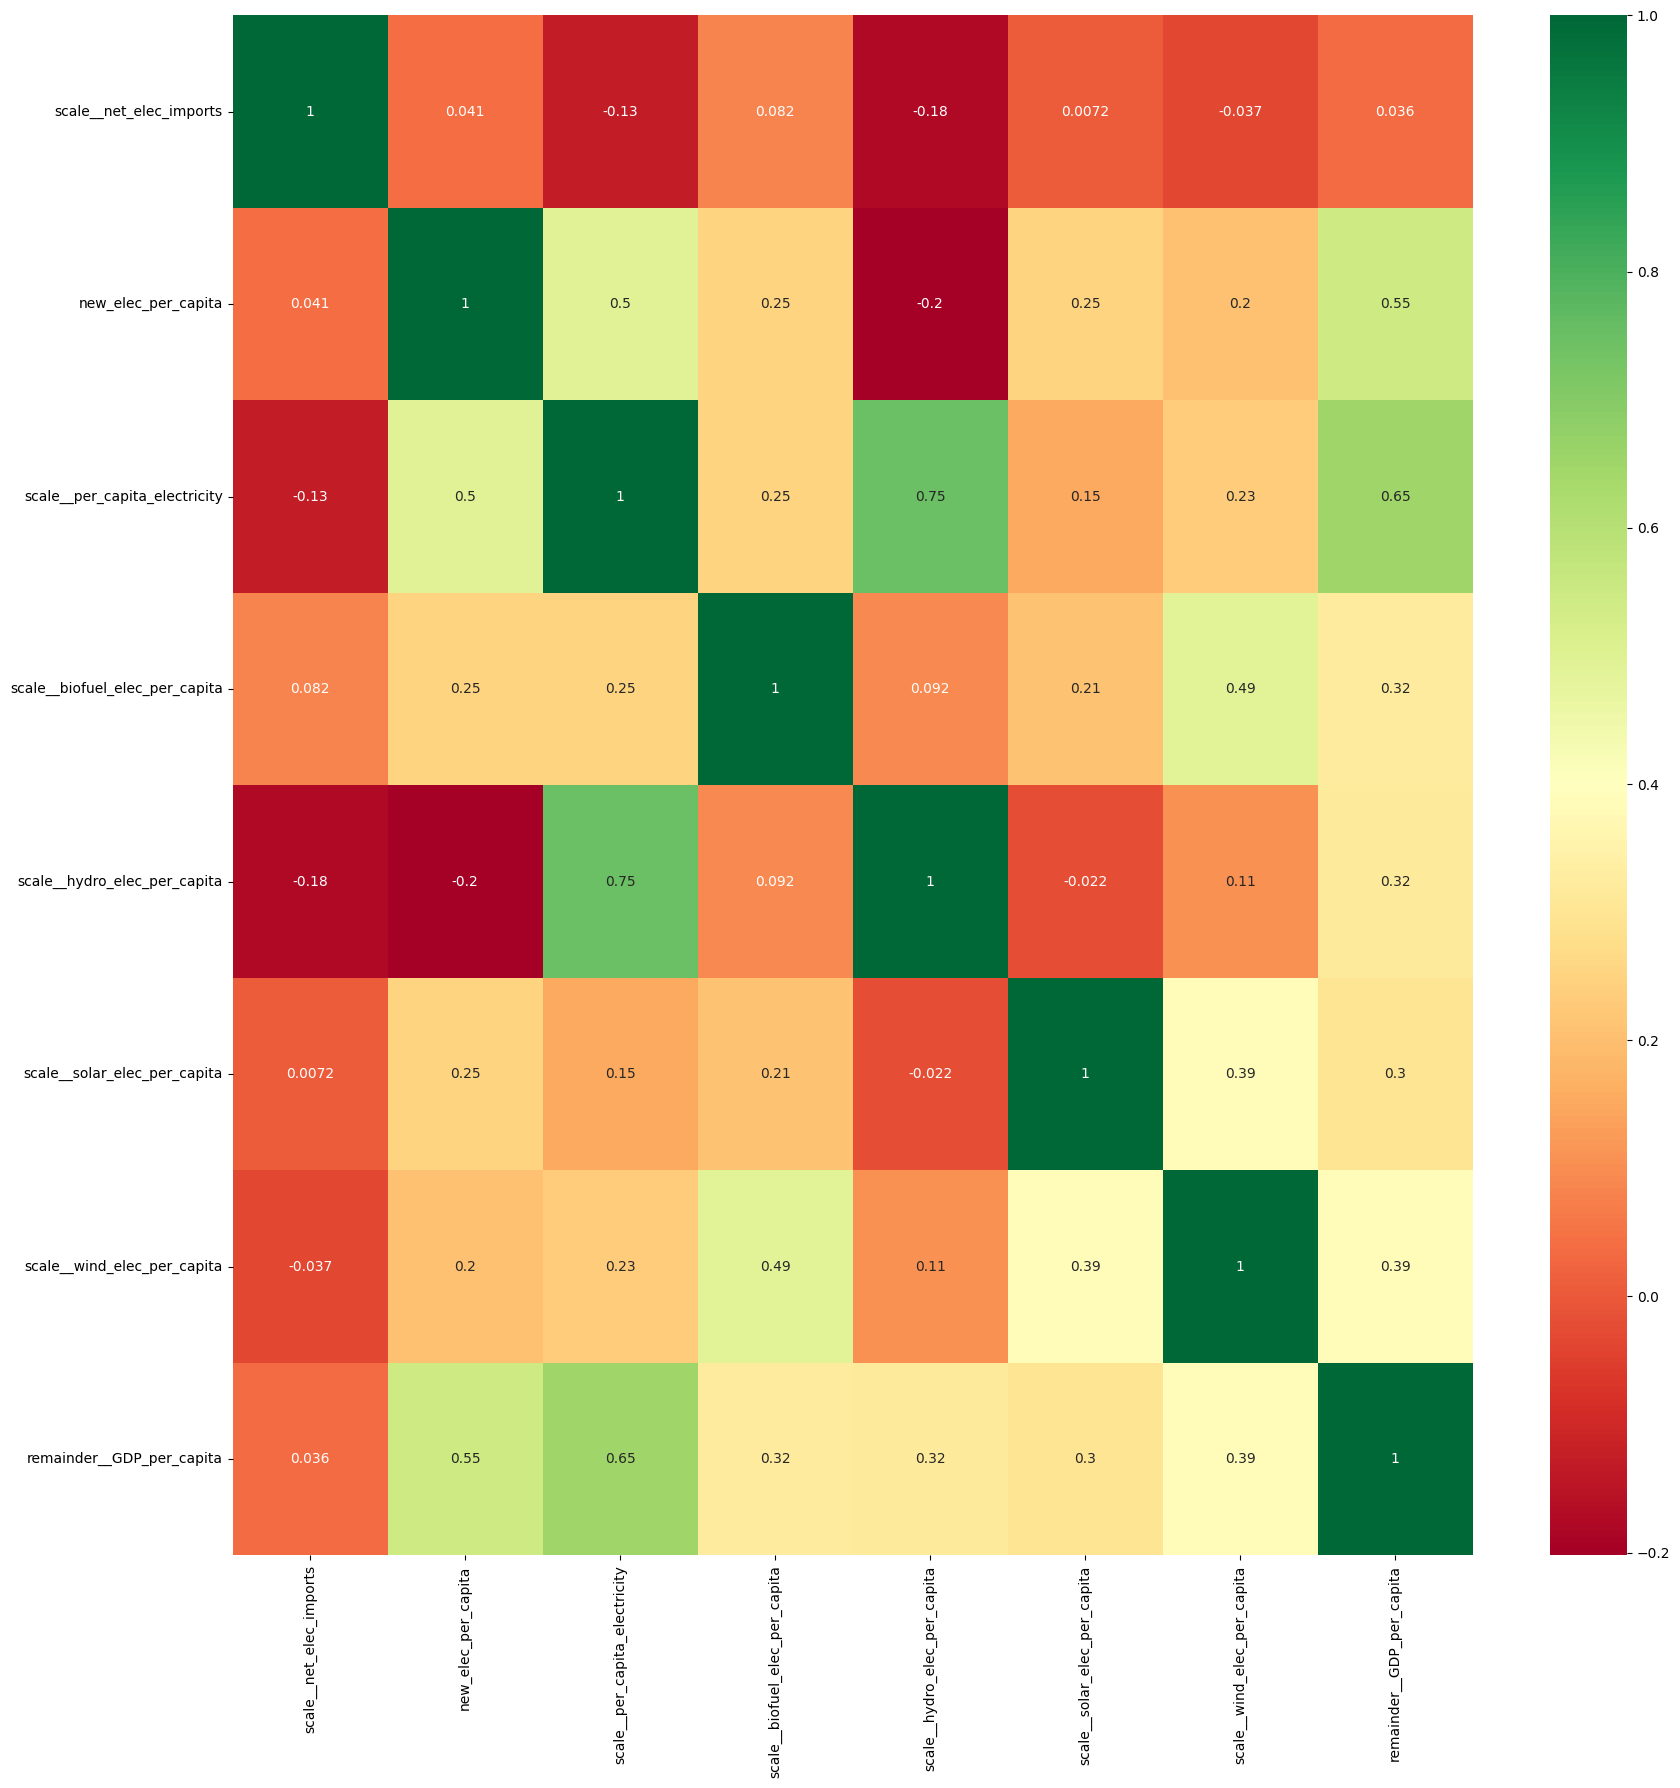

In [11]:
corrmat = full_cleaned_final[[  'scale__net_elec_imports',
                                'new_elec_per_capita',
                                'scale__per_capita_electricity', 
                                'scale__biofuel_elec_per_capita',
                                'scale__hydro_elec_per_capita', 
                                'scale__solar_elec_per_capita',
                                'scale__wind_elec_per_capita', 
                                'remainder__GDP_per_capita'
                       ]].corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(full_cleaned_final[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [12]:
#full_cleaned_final['scale__all_renewable'] = np.array(full_cleaned_final['scale__biofuel_electricity'])-np.array(full_cleaned_final['scale__wind_electricity'])+2*np.array(full_cleaned_final['scale__gas_production'])

#full_cleaned_final_test['scale__all_renewable'] = np.array(full_cleaned_final_test['scale__biofuel_electricity'])-np.array(full_cleaned_final_test['scale__wind_electricity'])+2*np.array(full_cleaned_final_test['scale__gas_production'])

In [13]:
full_cleaned_final.columns

Index(['scale__net_elec_imports', 'scale__per_capita_electricity',
       'scale__biofuel_elec_per_capita', 'scale__hydro_elec_per_capita',
       'scale__solar_elec_per_capita', 'scale__wind_elec_per_capita',
       'remainder__country', 'remainder__year', 'remainder__GDP_per_capita',
       'new_elec_per_capita'],
      dtype='object')

In [14]:
full_cleaned_final1 = full_cleaned_final.drop(columns=['remainder__year','remainder__country'])

In [15]:
full_cleaned_final1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4092 entries, 0 to 4091
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   scale__net_elec_imports         4092 non-null   float64
 1   scale__per_capita_electricity   4092 non-null   float64
 2   scale__biofuel_elec_per_capita  4092 non-null   float64
 3   scale__hydro_elec_per_capita    4092 non-null   float64
 4   scale__solar_elec_per_capita    4092 non-null   float64
 5   scale__wind_elec_per_capita     4092 non-null   float64
 6   remainder__GDP_per_capita       4092 non-null   float64
 7   new_elec_per_capita             4092 non-null   float64
dtypes: float64(8)
memory usage: 255.9 KB


In [16]:
full_cleaned_final1['remainder__GDP_per_capita'].head(3)

0    368.187174
1    378.391401
2    359.766343
Name: remainder__GDP_per_capita, dtype: float64

### Train on OLS model

In [17]:
X_train = full_cleaned_final_train[['scale__net_elec_imports',
                                    'new_elec_per_capita',
                                    'scale__hydro_elec_per_capita',
                                    'scale__biofuel_elec_per_capita',
                                    'scale__solar_elec_per_capita',
                                    'scale__wind_elec_per_capita']]

X_test = full_cleaned_final_test[['scale__net_elec_imports',
                                  'new_elec_per_capita',                                  
                                  'scale__hydro_elec_per_capita',
                                  'scale__biofuel_elec_per_capita',
                                  'scale__solar_elec_per_capita',
                                  'scale__wind_elec_per_capita']]


y_train = full_cleaned_final_train[['remainder__GDP_per_capita']]
y_test = full_cleaned_final_test[['remainder__GDP_per_capita']]

# Trying Ridge

In [18]:
Poly_model = PolynomialFeatures(degree=3)
ridge_model = Ridge(alpha=0.1)  # alpha controls the strength of the regularization

# Create a pipeline to combine the polynomial features and the Ridge model
pipeline = make_pipeline(Poly_model, ridge_model)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)


# Evaluate the pipeline on the test data
score = pipeline.score(X_test, y_test)
print(score, 'test_score')

y_pred = pipeline.predict(X_train)

r2_score_train=r2_score(y_train,y_pred)
print(r2_score_train, 'train score')

0.5953353390414113 test_score
0.6402114363746835 train score


In [19]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the pipeline
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5)

# Print the mean and standard deviation of the cross-validation scores
print("Cross-validation scores:", cv_scores)
print("Mean cross-validation score:", cv_scores.mean())
print("Standard deviation of cross-validation scores:", cv_scores.std())

Cross-validation scores: [0.67133796 0.58085094 0.60525771 0.59584374 0.66734677]
Mean cross-validation score: 0.6241274233292657
Standard deviation of cross-validation scores: 0.037750849385542906


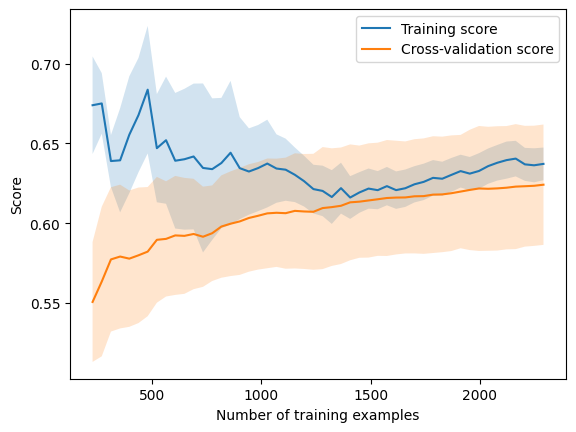

In [20]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# Define the training sizes
train_sizes = np.linspace(0.1, 1.0, 50)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, train_sizes=train_sizes, cv=5)

# Compute the mean and standard deviation of the training scores and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.xlabel("Number of training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

# Elastic Net

In [21]:
from sklearn.linear_model import ElasticNet

Poly_model = PolynomialFeatures(degree=4)
elasticnet_model = ElasticNet(alpha=0.1, l1_ratio=0.4)  # alpha controls the strength of the regularization, l1_ratio controls the balance between L1 and L2 regularization

# Create a pipeline to combine the polynomial features and the ElasticNet model
pipeline = make_pipeline(Poly_model, elasticnet_model)

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Evaluate the pipeline on the test data
score = pipeline.score(X_test, y_test)
score

0.1450796916914946

# Decision Tree

In [22]:
np.sqrt(X_train.shape[0])

53.51635264103861

In [23]:



# Create a decision tree regressor

print('Starting')
for a in range(3, 10):
    for b in range(2, 12):
        for c in range(1, 10):
            tree = DecisionTreeRegressor(max_depth=a, 
                                         criterion='friedman_mse',
                                         random_state=0,
                                         min_samples_split=b, 
                                         min_samples_leaf=c, 
                                         min_weight_fraction_leaf=0.0, 
                                         max_features=None,
                                         max_leaf_nodes=None, 
                                         min_impurity_decrease=0, 
                                         ccp_alpha=0.1)
            
            # Fit the model to the training data
            tree.fit(X_train, y_train)
            
            
            # Evaluate the model on the training data
            y_train_pred = tree.predict(X_train)
            r2_train = r2_score(y_train, y_train_pred)
            
            # Evaluate the model on the test data
            y_test_pred = tree.predict(X_test)
            r2_test = r2_score(y_test, y_test_pred)
            
            # Compute the mean absolute error
            mae = mean_absolute_error(y_test, y_test_pred)
            
            # Compute the mean squared error
            mse = mean_squared_error(y_test, y_test_pred)
            
            if r2_train - r2_test < 0.03 and r2_test > 0.625:
                print(a, b, c)
                print("Training set R^2 score:", r2_train)
                print("Test set R^2 score:", r2_test)
                if r2_train - r2_test < 0.04:
                    print('found the model  '*6)
                    
                print("Test set mean absolute error:", mae)
                if mae < 3300:
                    print('   *'*30)
                print("Test set mean squared error:", mse)
                print("-"*50)
print('finished')

Training set R^2 score: 0.8998508503754291
Test set R^2 score: 0.8317197973189769
Test set mean absolute error: 2965.6134081667633
   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *   *
Test set mean squared error: 67690121.83288951
--------------------------------------------------


# Random Forest

Converting y to an array

In [24]:
y_train = np.array(y_train).reshape(2864,)
y_train.shape

(2864,)

The model below has been tuned from a Decision Tree model above. Subsequently the random forest improve the model's score.

In [51]:
rf = RandomForestRegressor(n_estimators=80, 
                            criterion='friedman_mse', 
                            max_depth=3, 
                            min_samples_split=2, 
                            min_samples_leaf=3, 
                            max_features=None, 
                            max_leaf_nodes=None, 
                            min_impurity_decrease=0.1, 
                            bootstrap=True, 
                            oob_score=False, 
                            n_jobs=-1, 
                            random_state=0, 
                            verbose=0, 
                            warm_start=False, 
                            ccp_alpha=0.1, 
                            max_samples=None)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Evaluate the model on the training data
y_train_pred = rf.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate the model on the test data
y_test_pred = rf.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)

# Compute the mean absolute error
mae = mean_absolute_error(y_test, y_test_pred)

# Compute the mean squared error
mse = mean_squared_error(y_test, y_test_pred)

# Print the results
print("Training set R^2 score:", r2_train)
print("Test set R^2 score:", r2_test)
if r2_train-r2_test < 0.04:
    print('found the model  '*6)
    
print("Test set mean absolute error:", mae)
print("Test set mean squared error:", mse)
print("-"*50)

Training set R^2 score: 0.6670975529002438
Test set R^2 score: 0.654623776230026
found the model  found the model  found the model  found the model  found the model  found the model  
Test set mean absolute error: 6311.105012665451
Test set mean squared error: 138926375.72755468
--------------------------------------------------


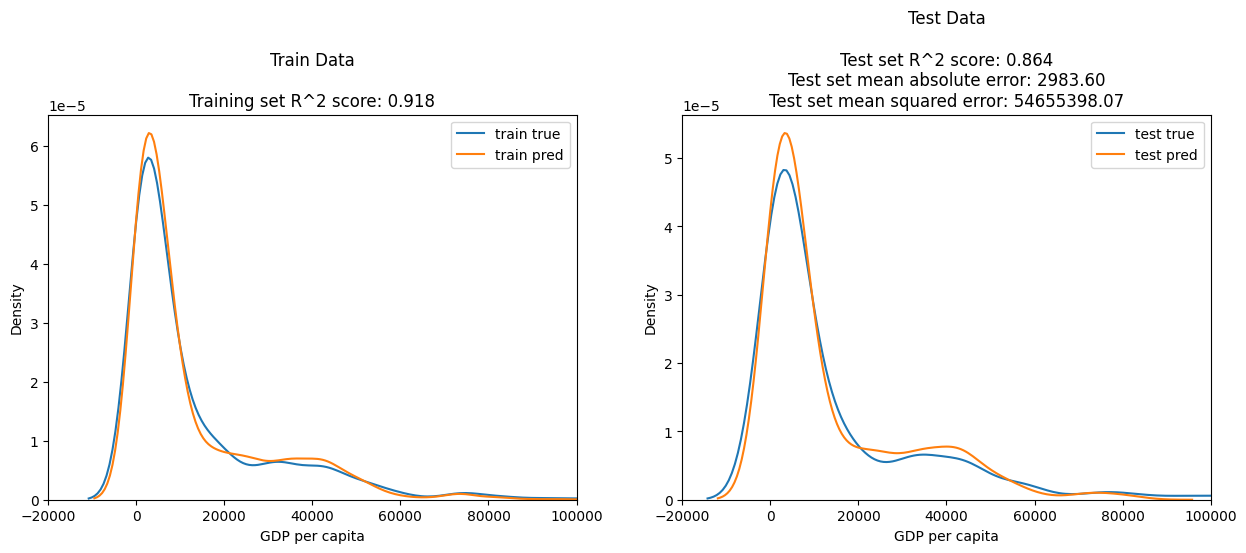

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot train data
sns.kdeplot(y_train, label='train true', ax=ax1)
sns.kdeplot(y_train_pred, label='train pred', ax=ax1)
ax1.set_xlim(-20000, 100000)
ax1.legend()
ax1.set_xlabel('GDP per capita')
ax1.set_ylabel('Density')
ax1.set_title(f'Train Data\n\nTraining set R^2 score: {r2_score(y_train, y_train_pred):.3f}')

# plot test data
sns.kdeplot(y_test['remainder__GDP_per_capita'], label='test true', ax=ax2)
sns.kdeplot(y_test_pred, label='test pred', ax=ax2)
ax2.set_xlim(-20000, 100000)
ax2.legend()
ax2.set_xlabel('GDP per capita')
ax2.set_ylabel('Density')
ax2.set_title(f'Test Data\n\nTest set R^2 score: {r2_score(y_test, y_test_pred):.3f}\nTest set mean absolute error: {mean_absolute_error(y_test, y_test_pred):.2f}\nTest set mean squared error: {mean_squared_error(y_test, y_test_pred):.2f}')

# Add model found message
if r2_score(y_train, y_train_pred) - r2_score(y_test, y_test_pred) < 0.04:
    for ax in [ax1, ax2]:
        ax.set_title(ax.get_title() + "\n\nFound the model!" * 6)

plt.show()

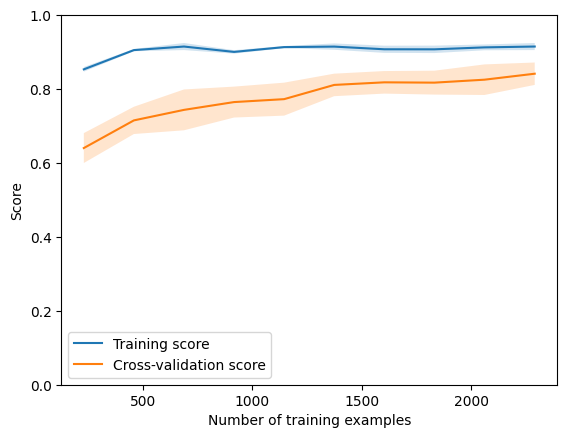

In [33]:
# Define the training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(rf, X_train, y_train, train_sizes=train_sizes, cv=5)

# Compute the mean and standard deviation of the training scores and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.plot(train_sizes, train_mean, label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)
plt.xlabel("Number of training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.ylim(0, 1)
plt.show()